In [1]:
print('Arabic Font Classification Project!!')

Arabic Font Classification Project!!


# Classification Methods
In this lab, it is required to identify between different hand-drawn shapes; such as rectangles, circles, triangles, ellipses, polygons, etc.

We will start our first lab in this course by understanding the main pipeline of any machine learning project:

**Important Note:** **Read all the code and fill the required functions in the 'utils' notebook as you go.**

In [2]:
#Always make all imports in the first cell of the notebook, run them all once.
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.filters import threshold_otsu
from __future__ import division
import numpy as np
from scipy.signal import convolve2d
from sklearn import svm ,metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# for NN:
import keras
from keras.models import Sequential
from keras.layers import Dense


%matplotlib inline

# A Machine Learning (ML) project is divided into many stages:

## 1. Gathering Data (Data Acquisition):

The first real step of machine learning is gathering data. This step is very important because the **quality and quantity** of data that you gather will directly determine how good your predictive model can be.

We define placeholders for the data as follows: 
* **x_train:** This represents the images in the training set. 
* **y_train:** This represents the labels of the images in the training set.  

In [3]:
x_train = []
y_train = []
y_train_nn = []
x_test = []
y_test = []
y_test_nn = []
styles = []


In [4]:
# load styles names:
with open('ACdata_base/names.txt') as file:
    lines = file.readlines()
    styles = [line.rstrip()[4:] for line in lines] # ignoring number at first of each style (first 4 chars)
print(styles)


['diwani', 'naskh', 'parsi', 'rekaa', 'thuluth', 'maghribi', 'kufi', 'mohakek', 'Squar-kufic']


In [5]:
## load styles images:
for i in range(1, len(styles)+1):
    for filename in sorted(glob.glob('ACdata_base/'+str(i)+'/*.jpg')):
        img = cv2.imread(filename) ## cv2.imread reads images in RGB format
        x_train.append(img)
        y_train.append(i-1)
        ynn = np.zeros(len(styles),dtype='float32')
        ynn[i-1] = 1.0
        y_train_nn.append(ynn)


for i in range(1, len(styles)+1):
    for filename in sorted(glob.glob('ACdata_base_test/'+str(i)+'/*.jpg')):
        img = cv2.imread(filename) ## cv2.imread reads images in RGB format
        x_test.append(img)
        y_test.append(i-1)
        ynn = np.zeros(len(styles),dtype='float32')
        ynn[i-1] = 1.0
        y_test_nn.append(ynn)

In [6]:
print(len(y_train_nn))
print(y_train_nn[0])

1505
[1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
# A good practice is to convert lists into numpy arrays. When it comes to actual machine learning algorithms, 
# it is better to work with NumPy arrays.
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
y_train_nn = np.asarray(y_train_nn)
#x_train = x_train.reshape(-1,1)
#y_train = y_train.reshape(-1,1)

print ("The size of the training set is: ", x_train.shape)

# We have a lot of images of different arabic styles, where each image is an RGB image of dimensions 200x200x3. 
# (images, height, width, channels)

print ("The size of the labels of the training set is: ", y_train.shape)
print (y_train)

The size of the training set is:  (1505,)
The size of the labels of the training set is:  (1505,)
[0 0 0 ... 8 8 8]


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


We will now visualize this dataset. 

**Note: You can run the following cell multiple times to view different shapes in the dataset as well as the ground-truth value associated with this training image.**

The ground-truth value of this image is:  diwani


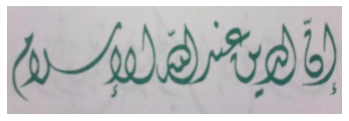

In [8]:
# Generate a random index from 0 to 18 inclusive. 
random_index = np.random.randint(0,18)

# Plot the image.
plt.imshow(x_train[random_index])
plt.axis("off")

print("The ground-truth value of this image is: " , styles[y_train[random_index]])

- - -
# 2. Data Preprocessing:

The second stage is to convert the raw data into a clean data set. In other words, whenever the data is gathered from different sources it is collected in raw format which is not feasible for the analysis. We need to prepare it to be suitable for our problem.

In this step, we will apply preprocessing to the images in **x_train** as follows: 
   1. Convert RGB images to grayscale images. Use the function **cv2.cvtColor** 
   2. Remove noise in images by blurring (averaging). Use the function **cv2.blur**
   3. Applying a binary threshold on the image pixels. Use the function **cv2.threshold**. The pixels having intensity less than this threshold should be considered black pixels, and white otherwise. 

In [9]:
def preprocess(img):
    # Preprocess the given image img.
    #-----------------------------------------------------------------------------------------------
    # Convert the image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #-----------------------------------------------------------------------------------------------
    #Convert the grayscale image to a binary image. Apply a threshold using Otsu's method on the blurred image.
    # get the threshold of the image using Otsu's method
    thresh = threshold_otsu(gray)
    thresholded_img = gray > thresh
    #_, thresholded_img = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
    #-----------------------------------------------------------------------------------------------
    return thresholded_img

In [10]:
# We will apply the function you implemented for each image in the training set (x_train) 
# and add the pre-processed images to a new list (x_train_preprocessed.)
x_train_preprocessed = []

for i in range(x_train.shape[0]):
    preprocessed_img = preprocess(x_train[i])
    x_train_preprocessed.append(preprocessed_img)

# Question 1: Should we do anything for y_train? 
# No as it is just a label (No change required to y_train)

In [11]:
# Let's inspect what happened after preprocessing 

#-----------------------------------------------------------------------------------------------
# TODO 4: Convert x_train_preprocessed into numpy array. 
x_train_preprocessed = np.asarray(x_train_preprocessed)
#-----------------------------------------------------------------------------------------------

#-----------------------------------------------------------------------------------------------
# TODO 5: Print the shape of the new preprocessed training set
shape = x_train_preprocessed.shape 
print ("The size of the training set is: ", shape)
#-----------------------------------------------------------------------------------------------


# Question 2: What has changed after pre-processing?
# it's shape has changed -> only one channel (Gray one)

The size of the training set is:  (1505,)


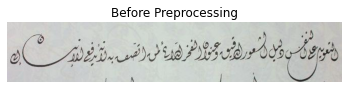

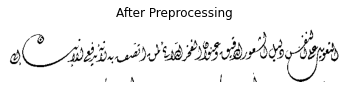

In [12]:
# Let's visualize what happened after preprocessing 

# Generate a random index from 0 to 18 inclusive. 
random_index = np.random.randint(0,18)

# Plot the image before preprocessing.
plt.imshow(x_train[random_index],cmap='gray')
plt.axis("off")
plt.title("Before Preprocessing")
plt.show()

# Plot the image after preprocessing.
plt.imshow(x_train_preprocessed[random_index],cmap='gray')
plt.axis("off")
plt.title("After Preprocessing")
plt.show()


In [13]:
# We do not need the original x_train anymore. We will work on x_train_preprocessed from now on. 
x_train = x_train_preprocessed


- - -
# 3. Feature Extraction: 

Now that we have clean and preprocessed data, we can use it to solve our classification problem.

This step could be either:
    
* **Feature Engineering:** transformation of raw data into features suitable for modeling.

* **Feature Transformation:** transformation of data to improve the accuracy of the algorithm.

* **Feature Selection:** removing unnecessary features.
    
The process of feature extraction in our problem can have many designs:

* One design is to extract the number of black pixels compared to the number of white pixels in each image and use this feature to differentiate between different shapes. (Is this a powerful feature?) Can you think of other features?


A more powerful set of features can be obtained by computing the convex hull of these shapes, and compare the area of this convex hull with the minimum enclosing circle, minimum enclosing rectangle and minimum enclosing triangle bounding that figure.


In the example above, the ratio between the areas of the convex hull (traingular figure) to the area of the bounding triangle will be maximum, and relatively smaller for the bounding rectangle and circle respectively. 

On the other hand, if the given shape was a circle, then the ratio between the areas of the shape to the bounding circle will be maximum and smaller for the bounding rectangle and triangle. 

Therefore, each image will be represented with a feature vector in three dimensions **(x, y and z)** where each component represents the ratio between the area of the figure to the area of the bounding rectangle, circle and triangle respectively.

**The images in the example above can be represented as a feature vector (0.67, 0.58, 0.92)**

We will now implement all functions needed for feature extraction.

In [14]:
# 2. LPQ "Local Phase Quantization" Feature Extraction:
def lpq(img,winSize=5,freqestim=1,mode='nh'):
    rho=0.90

    STFTalpha=1/winSize  # alpha in STFT approaches (for Gaussian derivative alpha=1)
    sigmaS=(winSize-1)/4 # Sigma for STFT Gaussian window (applied if freqestim==2)
    sigmaA=8/(winSize-1) # Sigma for Gaussian derivative quadrature filters (applied if freqestim==3)

    convmode='valid' # Compute descriptor responses only on part that have full neigborhood. Use 'same' if all pixels are included (extrapolates np.image with zeros).

    img=np.float64(img) # Convert np.image to double
    r=(winSize-1)/2 # Get radius from window size
    x=np.arange(-r,r+1)[np.newaxis] # Form spatial coordinates in window

    if freqestim==1:  #  STFT uniform window
        #  Basic STFT filters
        w0=np.ones_like(x)
        w1=np.exp(-2*np.pi*x*STFTalpha*1j)
        w2=np.conj(w1)

    ## Run filters to compute the frequency response in the four points. Store np.real and np.imaginary parts separately
    # Run first filter
    filterResp1=convolve2d(convolve2d(img,w0.T,convmode),w1,convmode)
    filterResp2=convolve2d(convolve2d(img,w1.T,convmode),w0,convmode)
    filterResp3=convolve2d(convolve2d(img,w1.T,convmode),w1,convmode)
    filterResp4=convolve2d(convolve2d(img,w1.T,convmode),w2,convmode)

    # Initilize frequency domain matrix for four frequency coordinates (np.real and np.imaginary parts for each frequency).
    freqResp=np.dstack([filterResp1.real, filterResp1.imag,
                        filterResp2.real, filterResp2.imag,
                        filterResp3.real, filterResp3.imag,
                        filterResp4.real, filterResp4.imag])

    ## Perform quantization and compute LPQ codewords
    inds = np.arange(freqResp.shape[2])[np.newaxis,np.newaxis,:]
    LPQdesc=((freqResp>0)*(2**inds)).sum(2)

    ## Switch format to uint8 if LPQ code np.image is required as output
    if mode=='im':
        LPQdesc=np.uint8(LPQdesc)

    ## Histogram if needed
    if mode=='nh' or mode=='h':
        LPQdesc=np.histogram(LPQdesc.flatten(),range(256))[0]

    ## Normalize histogram if needed
    if mode=='nh':
        LPQdesc=LPQdesc/LPQdesc.sum()

    #print(LPQdesc)
    return LPQdesc

We finally populate the array **training_features** with the extracted features from each image using the functions you implemented earlier. 

## Visualize the Features
A very useful step here is to visualize your features, see how they separate different classes from one another, and how they group data points from the same class closer together.

In [15]:
features = [lpq(x,winSize=5) for x in x_train]
features= np.array(features)

In [16]:
print(len(features))
print(len(features[0]))

1505
255


In [17]:
x_test = [lpq(preprocess(im)) for im in x_test]
x_test = np.array(x_test)

# # plt.hist(features[1]*256,bins=256)
# # loop on 20% features.shape[0] (1685) randomly add them to x_test
# print(features.shape[0])
# x_test=[]
# y_test=[]
# for i in range(int(0.2*features.shape[0])):
#     random_index = np.random.randint(0,features.shape[0])
#     x_test.append(features[random_index])
#     y_test.append(y_train[random_index])
# x_test = np.array(x_test)
# y_test = np.array(y_test)

# print(len(x_test),len(y_test))

- - -
# 4. ML Model: 
It’s time to feed the crafted features to the classification algorithm that is going to classify or predict the class of unknown or newly unseen data (called testing data). The process of choosing which classification algorithm will yield the best results is not an easy one. It is often subject to many iterations of tuning parameters and features.

In this lab, we will apply three classification algorithms and compare their results:
1. **SVM.**
2. **Radnom Forest.**
3. **K-Nearest Neighbour Classifier.**


In [18]:
#SVM CLASSIFIER

# average setting, one of [None, 'micro', 'macro', 'weighted'].

clf = svm.SVC(kernel='poly',degree=2,C=500,probability=True)
print(features.shape)
clf.fit(features, y_train)
y_preds = clf.predict(x_test)
y_probabilitiesSVM = clf.predict_proba(x_test)

print("probabilities:",np.round(y_probabilitiesSVM[35:45],2))
print("Accuracy:",round(metrics.accuracy_score(y_test, y_preds)*100,2) ,'%')
print("Precision:",round(metrics.precision_score(y_test, y_preds,average='weighted')*100,2),'%')
print("Recall:",round(metrics.recall_score(y_test, y_preds,average='weighted')*100,2),'%')
print("f1 score:",round(metrics.f1_score(y_test, y_preds,average='weighted')*100,2),'%')


(1505, 255)
probabilities: [[0.02 0.81 0.09 0.02 0.   0.03 0.   0.02 0.  ]
 [0.01 0.93 0.   0.01 0.   0.01 0.   0.03 0.  ]
 [0.01 0.86 0.01 0.02 0.   0.04 0.   0.05 0.  ]
 [0.03 0.86 0.01 0.01 0.   0.02 0.   0.07 0.  ]
 [0.01 0.9  0.01 0.01 0.   0.02 0.   0.05 0.  ]
 [0.01 0.   0.98 0.   0.01 0.   0.   0.   0.  ]
 [0.01 0.   0.96 0.   0.01 0.   0.   0.   0.  ]
 [0.14 0.26 0.52 0.05 0.   0.01 0.   0.01 0.  ]
 [0.   0.01 0.98 0.   0.   0.   0.   0.   0.  ]
 [0.01 0.02 0.96 0.01 0.   0.   0.   0.   0.  ]]
Accuracy: 93.89 %
Precision: 94.56 %
Recall: 93.89 %
f1 score: 93.75 %


In [19]:
# KNN CLASSIFIER

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(features, y_train)
y_predk = clf.predict(x_test)
y_probabilitiesKNN = clf.predict_proba(x_test)

print("probabilities:",np.round(y_probabilitiesKNN[35:45],2))
print("Accuracy:",round(metrics.accuracy_score(y_test, y_predk)*100,2) ,'%')
print("Precision:",round(metrics.precision_score(y_test, y_predk,average='weighted')*100,2),'%')
print("Recall:",round(metrics.recall_score(y_test, y_predk,average='weighted')*100,2),'%')
print("f1 score:",round(metrics.f1_score(y_test, y_predk,average='weighted')*100,2),'%')

probabilities: [[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Accuracy: 79.44 %
Precision: 84.0 %
Recall: 79.44 %
f1 score: 79.01 %


In [20]:
# Random Forest Tree CLASSIFIER

# average setting, one of [None, 'micro', 'macro', 'weighted'].

clf = RandomForestClassifier(max_depth=13, random_state=3,n_estimators=500)
print(features.shape)
clf.fit(features, y_train)
y_predr = clf.predict(x_test)
y_probabilitiesRF = clf.predict_proba(x_test)

print("probabilities:",np.round(y_probabilitiesRF[35:45],2))
print("Accuracy:",round(metrics.accuracy_score(y_test, y_predr)*100,2) ,'%')
print("Precision:",round(metrics.precision_score(y_test, y_predr,average='weighted')*100,2),'%')
print("Recall:",round(metrics.recall_score(y_test, y_predr,average='weighted')*100,2),'%')
print("f1 score:",round(metrics.f1_score(y_test, y_predr,average='weighted')*100,2),'%')

(1505, 255)
probabilities: [[0.04 0.65 0.11 0.02 0.   0.12 0.01 0.05 0.  ]
 [0.   0.92 0.01 0.01 0.   0.02 0.   0.03 0.  ]
 [0.03 0.86 0.03 0.01 0.   0.04 0.01 0.02 0.  ]
 [0.06 0.87 0.01 0.01 0.   0.03 0.   0.02 0.  ]
 [0.02 0.91 0.01 0.   0.   0.02 0.01 0.03 0.  ]
 [0.02 0.   0.92 0.05 0.   0.01 0.   0.   0.  ]
 [0.24 0.01 0.54 0.08 0.01 0.06 0.01 0.04 0.  ]
 [0.1  0.13 0.64 0.03 0.   0.06 0.01 0.02 0.  ]
 [0.15 0.08 0.69 0.04 0.   0.02 0.01 0.01 0.  ]
 [0.13 0.13 0.57 0.09 0.   0.04 0.01 0.02 0.  ]]
Accuracy: 90.0 %
Precision: 93.65 %
Recall: 90.0 %
f1 score: 90.01 %


In [21]:
# Neural network as a Classifier:

model = Sequential()
model.add(Dense(16, input_dim=len(features[0]), activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(9, activation='softmax'))

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# x_train=np.asarray(x_train).astype(int)
y_train_nn=np.asarray(y_train_nn).astype(np.float32)
features = np.asarray(features).astype(np.float32)
# y_train = np.asarray(y_train).astype(np.float32)
# ytrain for NN:    shayef sa7? Shoof kan fe moshkela en el ytrain el shape bta3ha 1 we e7na 3awzeno yetala3 9 probabilities
history = model.fit(features, y_train_nn, epochs=1000, batch_size=255)

y_prednn = model.predict(x_test)


Epoch 1/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.5269 - accuracy: 0.8279
Epoch 2/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.5239 - accuracy: 0.8299
Epoch 3/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.5219 - accuracy: 0.8292
Epoch 4/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.5207 - accuracy: 0.8286
Epoch 5/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.5187 - accuracy: 0.8306
Epoch 6/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.5176 - accuracy: 0.8306
Epoch 7/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.5158 - accuracy: 0.8312
Epoch 8/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.5147 - accuracy: 0.8292
Epoch 9/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.5127 - accuracy: 0.8306
Epoch 10/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.5126 - accuracy: 0.8299
Epoch 11/1000
6/6 [

6/6 [==============================] - 0s 3ms/step - loss: 0.4055 - accuracy: 0.8684
Epoch 84/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.4042 - accuracy: 0.8684
Epoch 85/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4024 - accuracy: 0.8671
Epoch 86/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.4015 - accuracy: 0.8671
Epoch 87/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3998 - accuracy: 0.8698
Epoch 88/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3984 - accuracy: 0.8671
Epoch 89/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3968 - accuracy: 0.8704
Epoch 90/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3955 - accuracy: 0.8718
Epoch 91/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3942 - accuracy: 0.8718
Epoch 92/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3930 - accuracy: 0.8724
Epoch 93/1000
6/6 [=====

6/6 [==============================] - 0s 4ms/step - loss: 0.3151 - accuracy: 0.9003
Epoch 166/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3145 - accuracy: 0.9010
Epoch 167/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3135 - accuracy: 0.9010
Epoch 168/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3134 - accuracy: 0.8990
Epoch 169/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3118 - accuracy: 0.8997
Epoch 170/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3111 - accuracy: 0.9017
Epoch 171/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3098 - accuracy: 0.9030
Epoch 172/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3097 - accuracy: 0.8997
Epoch 173/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3088 - accuracy: 0.9030
Epoch 174/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.3078 - accuracy: 0.9037
Epoch 175/1000


6/6 [==============================] - 0s 4ms/step - loss: 0.2543 - accuracy: 0.9196
Epoch 248/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.2536 - accuracy: 0.9203
Epoch 249/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.2527 - accuracy: 0.9196
Epoch 250/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.2525 - accuracy: 0.9216
Epoch 251/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.2518 - accuracy: 0.9189
Epoch 252/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.2509 - accuracy: 0.9196
Epoch 253/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.2505 - accuracy: 0.9209
Epoch 254/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.2498 - accuracy: 0.9196
Epoch 255/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.2493 - accuracy: 0.9203
Epoch 256/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.2484 - accuracy: 0.9216
Epoch 257/1000


6/6 [==============================] - 0s 4ms/step - loss: 0.2092 - accuracy: 0.9342
Epoch 329/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.2086 - accuracy: 0.9349
Epoch 330/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.2075 - accuracy: 0.9336
Epoch 331/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.2071 - accuracy: 0.9336
Epoch 332/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.2069 - accuracy: 0.9349
Epoch 333/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.2066 - accuracy: 0.9342
Epoch 334/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.2057 - accuracy: 0.9342
Epoch 335/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.2055 - accuracy: 0.9369
Epoch 336/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.2049 - accuracy: 0.9349
Epoch 337/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.2042 - accuracy: 0.9355
Epoch 338/1000


6/6 [==============================] - 0s 3ms/step - loss: 0.1717 - accuracy: 0.9488
Epoch 411/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.1715 - accuracy: 0.9495
Epoch 412/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.1709 - accuracy: 0.9488
Epoch 413/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.1708 - accuracy: 0.9495
Epoch 414/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.1703 - accuracy: 0.9495
Epoch 415/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.1699 - accuracy: 0.9488
Epoch 416/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.1694 - accuracy: 0.9502
Epoch 417/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.1689 - accuracy: 0.9502
Epoch 418/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.1687 - accuracy: 0.9488
Epoch 419/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.1685 - accuracy: 0.9495
Epoch 420/1000


6/6 [==============================] - 0s 4ms/step - loss: 0.1420 - accuracy: 0.9608
Epoch 493/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.1420 - accuracy: 0.9615
Epoch 494/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.1414 - accuracy: 0.9615
Epoch 495/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.1411 - accuracy: 0.9621
Epoch 496/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.1408 - accuracy: 0.9615
Epoch 497/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.1404 - accuracy: 0.9608
Epoch 498/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.1402 - accuracy: 0.9615
Epoch 499/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.1396 - accuracy: 0.9615
Epoch 500/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.1398 - accuracy: 0.9615
Epoch 501/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.1390 - accuracy: 0.9615
Epoch 502/1000


6/6 [==============================] - 0s 4ms/step - loss: 0.1185 - accuracy: 0.9688
Epoch 575/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.1182 - accuracy: 0.9688
Epoch 576/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.1179 - accuracy: 0.9694
Epoch 577/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.1178 - accuracy: 0.9681
Epoch 578/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.1173 - accuracy: 0.9688
Epoch 579/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.1174 - accuracy: 0.9688
Epoch 580/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.1169 - accuracy: 0.9688
Epoch 581/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.1168 - accuracy: 0.9681
Epoch 582/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.1168 - accuracy: 0.9688
Epoch 583/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.1164 - accuracy: 0.9688
Epoch 584/1000


6/6 [==============================] - 0s 4ms/step - loss: 0.0996 - accuracy: 0.9721
Epoch 657/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0993 - accuracy: 0.9734
Epoch 658/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0994 - accuracy: 0.9728
Epoch 659/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0990 - accuracy: 0.9734
Epoch 660/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0988 - accuracy: 0.9741
Epoch 661/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0985 - accuracy: 0.9734
Epoch 662/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0984 - accuracy: 0.9721
Epoch 663/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0984 - accuracy: 0.9748
Epoch 664/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0980 - accuracy: 0.9721
Epoch 665/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0981 - accuracy: 0.9721
Epoch 666/1000


6/6 [==============================] - 0s 4ms/step - loss: 0.0848 - accuracy: 0.9794
Epoch 739/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0849 - accuracy: 0.9801
Epoch 740/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0845 - accuracy: 0.9801
Epoch 741/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0841 - accuracy: 0.9807
Epoch 742/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0840 - accuracy: 0.9801
Epoch 743/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0842 - accuracy: 0.9807
Epoch 744/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0840 - accuracy: 0.9807
Epoch 745/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0836 - accuracy: 0.9807
Epoch 746/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0834 - accuracy: 0.9807
Epoch 747/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0833 - accuracy: 0.9807
Epoch 748/1000


6/6 [==============================] - 0s 4ms/step - loss: 0.0730 - accuracy: 0.9834
Epoch 820/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0728 - accuracy: 0.9841
Epoch 821/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0727 - accuracy: 0.9854
Epoch 822/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0726 - accuracy: 0.9834
Epoch 823/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0724 - accuracy: 0.9841
Epoch 824/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0720 - accuracy: 0.9854
Epoch 825/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0720 - accuracy: 0.9834
Epoch 826/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0717 - accuracy: 0.9847
Epoch 827/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0719 - accuracy: 0.9860
Epoch 828/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0716 - accuracy: 0.9847
Epoch 829/1000


6/6 [==============================] - 0s 4ms/step - loss: 0.0632 - accuracy: 0.9867
Epoch 901/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0629 - accuracy: 0.9867
Epoch 902/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0629 - accuracy: 0.9867
Epoch 903/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0629 - accuracy: 0.9867
Epoch 904/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0628 - accuracy: 0.9867
Epoch 905/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0625 - accuracy: 0.9867
Epoch 906/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0625 - accuracy: 0.9867
Epoch 907/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0622 - accuracy: 0.9860
Epoch 908/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0626 - accuracy: 0.9867
Epoch 909/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0622 - accuracy: 0.9867
Epoch 910/1000


6/6 [==============================] - 0s 3ms/step - loss: 0.0554 - accuracy: 0.9867
Epoch 983/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0555 - accuracy: 0.9867
Epoch 984/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0553 - accuracy: 0.9874
Epoch 985/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0556 - accuracy: 0.9867
Epoch 986/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0555 - accuracy: 0.9874
Epoch 987/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0552 - accuracy: 0.9880
Epoch 988/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0548 - accuracy: 0.9874
Epoch 989/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0549 - accuracy: 0.9874
Epoch 990/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0552 - accuracy: 0.9867
Epoch 991/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0550 - accuracy: 0.9874
Epoch 992/1000


In [43]:
print(y_prednn.shape)
print("probabilities:",np.round(y_prednn[55:65],2))
print("actual:",y_test[55:65])
y_prednn_labels = np.argmax(y_prednn,axis=1)
print("y_prednn_labels:",y_prednn_labels[55:65])
print("Accuracy:",round(metrics.accuracy_score(y_test, y_prednn_labels)*100,2) ,'%')
print("Precision:",round(metrics.precision_score(y_test, y_prednn_labels,average='weighted')*100,2),'%')
print("Recall:",round(metrics.recall_score(y_test, y_prednn_labels,average='weighted')*100,2),'%')
print("f1 score:",round(metrics.f1_score(y_test, y_prednn_labels,average='weighted')*100,2),'%')

(180, 9)
probabilities: [[0.23 0.   0.76 0.   0.   0.   0.   0.01 0.  ]
 [0.01 0.   0.98 0.   0.   0.   0.   0.02 0.  ]
 [0.   0.   0.83 0.   0.   0.   0.   0.17 0.  ]
 [0.03 0.   0.97 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.   0.   0.   0.   0.99 0.  ]
 [0.   0.   0.   0.98 0.   0.   0.02 0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.  ]]
actual: [2, 2, 2, 2, 2, 3, 3, 3, 3, 3]
y_prednn_labels: [2 2 2 2 7 3 3 3 3 3]
Accuracy: 92.78 %
Precision: 93.35 %
Recall: 92.78 %
f1 score: 92.62 %


In [45]:
# Neural network as a combination of Classifiers o/p:

model = Sequential()
model.add(Dense(16, input_dim=9*3, activation='tanh'))
model.add(Dense(9, activation='softmax'))

In [63]:
features_combine = np.concatenate((y_probabilitiesSVM, y_probabilitiesKNN , y_probabilitiesRF ), axis=1)
print(y_probabilitiesSVM.shape)
print(features_combine.shape)

print(x_test.shape)
y_test_nn= np.array(y_test_nn)
print(y_test_nn.shape)

(180, 9)
(180, 27)
(180, 255)
(180, 9)


In [51]:
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# x_train=np.asarray(x_train).astype(int)
#y_train_nn=np.asarray(y_train_nn).astype(np.float32)

#history = model.fit(features_combine, y_train_nn, epochs=1000, batch_size=255)

#y_predAll = model.predict(x_test)


ValueError: Data cardinality is ambiguous:
  x sizes: 540
  y sizes: 1505
Make sure all arrays contain the same number of samples.

- - -
# 5. Performance Results: 
After training the classifier with the training data, it’s time to test its accuracy against testing data (i.e. data that is unseen or new for the classification algorithm). The accuracy is reported as the percentage of the number of instances that were correctly classified to the total number of instances.

Computing the following metrics
  1. **Accuracy.**
  2. **Precision.**
  3. **Recall.**
  4. **f1 score**

In [44]:

#SVM
print('----------------------------------------------------------------')
print("Support Vector MAchine:")
print('----------------------------------------------------------------')

print("Accuracy:",round(metrics.accuracy_score(y_test, y_preds)*100,2) ,'%')
print("Precision:",round(metrics.precision_score(y_test, y_preds,average='weighted')*100,2),'%')
print("Recall:",round(metrics.recall_score(y_test, y_preds,average='weighted')*100,2),'%')
print("f1 score:",round(metrics.f1_score(y_test, y_preds,average='weighted')*100,2),'%')

print('----------------------------------------------------------------')
#KNN
print("K-Nearest Neighbour:")
print('----------------------------------------------------------------')


print("Accuracy:",round(metrics.accuracy_score(y_test, y_predk)*100,2) ,'%')
print("Precision:",round(metrics.precision_score(y_test, y_predk,average='weighted')*100,2),'%')
print("Recall:",round(metrics.recall_score(y_test, y_predk,average='weighted')*100,2),'%')
print("f1 score:",round(metrics.f1_score(y_test, y_predk,average='weighted')*100,2),'%')

print('----------------------------------------------------------------')
#Random Forest Tree
print("Random Forest Tree:")
print('----------------------------------------------------------------')

print("Accuracy:",round(metrics.accuracy_score(y_test, y_predr)*100,2) ,'%')
print("Precision:",round(metrics.precision_score(y_test, y_predr,average='weighted')*100,2),'%')
print("Recall:",round(metrics.recall_score(y_test, y_predr,average='weighted')*100,2),'%')
print("f1 score:",round(metrics.f1_score(y_test, y_predr,average='weighted')*100,2),'%')
print('----------------------------------------------------------------')

#Neural Network as a Classifier
print("Neural Network as a Classifier:")
print('----------------------------------------------------------------')

print("Accuracy:",round(metrics.accuracy_score(y_test, y_prednn_labels)*100,2) ,'%')
print("Precision:",round(metrics.precision_score(y_test, y_prednn_labels,average='weighted')*100,2),'%')
print("Recall:",round(metrics.recall_score(y_test, y_prednn_labels,average='weighted')*100,2),'%')
print("f1 score:",round(metrics.f1_score(y_test, y_prednn_labels,average='weighted')*100,2),'%')
print('----------------------------------------------------------------')


----------------------------------------------------------------
Support Vector MAchine:
----------------------------------------------------------------
Accuracy: 93.89 %
Precision: 94.56 %
Recall: 93.89 %
f1 score: 93.75 %
----------------------------------------------------------------
K-Nearest Neighbour:
----------------------------------------------------------------
Accuracy: 79.44 %
Precision: 84.0 %
Recall: 79.44 %
f1 score: 79.01 %
----------------------------------------------------------------
Random Forest Tree:
----------------------------------------------------------------
Accuracy: 90.0 %
Precision: 93.65 %
Recall: 90.0 %
f1 score: 90.01 %
----------------------------------------------------------------
Neural Network as a Classifier:
----------------------------------------------------------------
Accuracy: 92.78 %
Precision: 93.35 %
Recall: 92.78 %
f1 score: 92.62 %
----------------------------------------------------------------
